### En el grupo está cómo calculé estas functiones

In [25]:
import matplotlib.pyplot as plt
import numpy as np

In [26]:
g = 9.81 * 100 / (1000 * 1000) # m/s^2 a cm/(ms^2)

def get_mu_d(a, M, m, g=g):
    return ( a * (m + M) + M*g ) / ( m*g )


def get_error_mu_d(M, m, a, dM, dm, da, g=9.81):
    mu_d = (M * g + (m + M) * a) / (m * g)
    
    # Partial derivatives
    d_mu_d_M = (g + a) / (m * g)
    d_mu_d_m = -mu_d / m
    d_mu_d_a = (m + M) / (m * g)
    
    # Error propagation
    error_mu_d = np.sqrt((d_mu_d_M * dM)**2 + (d_mu_d_m * dm)**2 + (d_mu_d_a * da)**2)
    
    return error_mu_d

In [27]:
TRINEO = 110 # g
DTRINEO = 1 # g

PLATA = 23 # g
DPLATA = 1 # g

MADERA = 6 # g
DMADERA = 1 # g

ORO = 72 # g
DORO = 1 # g

### Mu dinámico para Mesa

In [28]:
g = 9.81 * 100 / (1000 * 1000)  # Convert g to cm/ms^2


# Dos Plata y Madera Arriba, Oro Abajo
m1 = 2 * PLATA + MADERA + TRINEO
dm1 = 2 * DPLATA + DMADERA + DTRINEO
M1 = ORO
dM1 = DORO

# Intento 1
a11 = 1.19 * 10**(-5)
da11 = 4.9 * 10**(-6)

mu_d1 = get_mu_d(a11, M1, m1)
dmu_d1 = get_error_mu_d(M1, m1, a11, dM1, dm1, da11)

# Intento 2
## FIX DATA

# Madera y Oro Arriba, Dos Plata Abajo
m2 = MADERA + ORO + TRINEO
dm2 = DMADERA + DORO + DTRINEO
M2 = 2 * PLATA
dM2 = 2 * DPLATA

# Intento 2
a21 = 1.66 * 10**(-5)
da21 = 9.46 * 10**(-7)

mu_d2 = get_mu_d(a21, M2, m2)
dmu_d2 = get_error_mu_d(M2, m2, a21, dM2, dm2, da21)

print(f"mu_d1 = {mu_d1} +- {dmu_d1}")
print(f"mu_d2 = {mu_d2} +- {dmu_d2}")


mu_d1 = 0.46196624759315885 +- 0.01259096029554206
mu_d2 = 0.2657427288698029 +- 0.011332210913287434


In [29]:
def plot_mus_d_with_error_bar(mus_d, sigmas_mus_d, mean, error):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the data points with error bars
    ax.errorbar(range(len(mus_d)), mus_d, yerr=sigmas_mus_d, fmt='o', color='blue', capsize=5, elinewidth=2, markeredgewidth=2, label='Datos experimentales')
    
    if mean is not None:
        # Plot the mean line in red
        ax.axhline(mean, color='red', linewidth=2, label='Promedio')

    # Plot the error bounds using fill_between
    if error is not None:
        ax.fill_between(range(len(mus_d)), mean - error, mean + error, color='red', alpha=0.2, label='Intervalo de error')

    # Customize the x-axis to show integer ticks for each measurement
    ax.set_xticks(range(len(mus_d)))
    ax.set_xticklabels([f'Intento {i+1}' for i in range(len(mus_d))])
    
    # Customize labels and title
    ax.set_xlabel('Intento', fontsize=14)
    ax.set_ylabel('$\mu_d$', fontsize=14)

    # Add legend
    ax.legend(fontsize=12)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
C:\Users\xxx\AppData\Local\Temp\ipykernel_18020\2661245862.py:21: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mu_d$', fontsize=14)


In [30]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np

def format_pd(data, intento):

    data = data[data["Intento"] == intento].copy() 

    # Esto es para que arranque en 365 una vez (lo hizo chat obviamente)
    mask = (data['x'] != 365.00) | (data['x'].shift(-1) != 365.00)

    data = data[mask]

    # Arranca en t = 0
    data["t"] = data["t"] - data["t"].min()

    data = data.drop(columns=["Intento"])
    
    return data

def modelo_cuadratico(t, a, b, c):
    return a * t**2 + b * t + c

# FUNCIONES SACADAS DE CALIBRACIÓN

def distancia(v):
    return 0.0178*v - 1.2753

def sigma_d(v):
    return 0.0007*v + 1.1673

def f_propagacion_errores(t, popt, errores_x):
    """
    Function to propagate the errors based on the fit parameters and x-axis errors.
    
    Parameters:
    t (array-like): Independent variable (time) data points
    popt (array-like): Fitted parameters from curve_fit
    errores_x (array-like): Error values for the independent variable data points (x-axis)
    
    Returns:
    sigma_d_t (array-like): Propagated uncertainty in the dependent variable (y-axis)
    """
    a, b, c = popt
    # Error propagation formula for quadratic fit
    sigma_d_t = np.sqrt((2 * a * t + b) ** 2 * errores_x ** 2)
    return sigma_d_t

g = 9.81 * 100 / (1000 * 1000)  # Convert g to cm/ms^2

In [31]:
def mean_with_sigma(mus_d, sigmas_mus_d):
    # Convert lists to numpy arrays
    mus_d = np.array(mus_d)
    sigmas_mus_d = np.array(sigmas_mus_d)
    
    # For every mu_d, we have its error sigma_mu_d
    # We can calculate the weighted mean as follows
    weighted_mean = np.sum(mus_d / sigmas_mus_d**2) / np.sum(1 / sigmas_mus_d**2)

    # The uncertainty in the weighted mean is given by
    sigma_weighted_mean = 1 / np.sqrt(np.sum(1 / sigmas_mus_d**2))

    return weighted_mean, sigma_weighted_mean

[0.08809526653377536, 0.14553030325482771, 0.06565182191115784, 0.06122235606539679, 0.09780093336322561, 0.09733423511390701]
[0.012590960157264977, 0.012591095808249755, 0.011332210189429238, 0.011332204199644843, 0.015911691948585445, 0.015911691224545766]


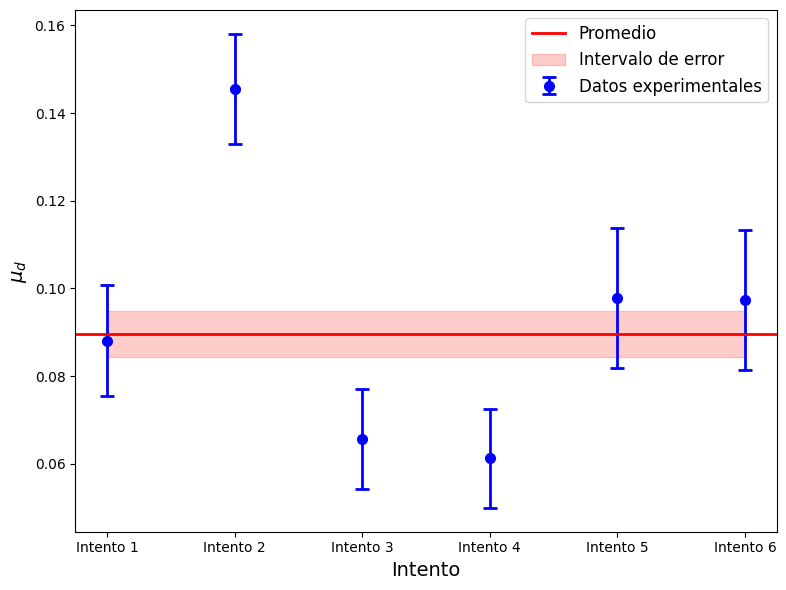

In [32]:
# HACER ESTO PARA CADA TIPO DE SUPERFICIE   

datasets = [
    { "file" : 'data_dosplataymadera_oro.csv', "m" : 110 + 2 * 23 + 6, "M" : 72, "dm": 4, "dM": 1 },
    { "file" : 'data_maderayoro_dosplata.csv', "m" : 110 + 6 + 72, "M" : 2 * 23 , "dm": 3, "dM": 2},
    { "file" : 'data_plata_dosplata.csv', "m" : 110 + 23, "M" : 2 * 23, "dm": 2, "dM": 2}
]

# datasets = [
#     { "file" : 'data_dosplata_oro_PAPEL.csv', "m" : 110 + 2 * 23, "M" : 72, "dm": 3, "dM": 1 },
#     { "file" : 'data_tresplata_oro_PAPEL.csv', "m" : 110 + 3 * 23, "M" : 2 * 23, "dm": 4, "dM": 2},
# ]



mus_d = []
errors_mu_d = []

for dataset in datasets:
    for i in range(1,3):
        data = pd.read_csv(dataset["file"])
        data = format_pd(data, i)
        M, m = dataset["M"], dataset["m"]
        # se lo sacó copilot del orto
        tiempo = data["t"].values
        posicion = distancia(data["x"].values)
        errores = sigma_d(data["x"].values)

        # Fit the quadratic model to the data
        popt, pcov = curve_fit(modelo_cuadratico, tiempo, posicion, sigma=errores, absolute_sigma=True)

        # Extract the fitted parameters and their uncertainties
        a, _, _ = popt
        error_a = np.sqrt(np.diag(pcov))[0]    
        
        mu = (M * g) + ( m + M ) * a / (m * g)
        dM = dataset["dM"]
        dm = dataset["dm"]
        error_mu = get_error_mu_d(M, m, a, dM, dm, error_a)
        mus_d.append(mu)
        errors_mu_d.append(error_mu)

print(mus_d)
print(errors_mu_d)

mean, overall_error = mean_with_sigma(mus_d, errors_mu_d)

plot_mus_d_with_error_bar(mus_d, errors_mu_d, mean, overall_error)

# Gráfico de relación entre rozamiento dinámico y M / m

$$

\mu_d = \frac{M g + (m + M) \ddot{x}}{m g}
$$

In [33]:

def propagacion_errores_ratios(M, m, dM=1, dm=1):
    #return np.sqrt((dM / m)**2 + (M * dm / m**2)**2) # Esto está bien, pero sobreestima mucho y arruina todo
    return ((1 - dm) * M  + dM) / (m * dm)


In [34]:

# Calcular aceleración

datasets = [
    { "file" : 'data_dosplataymadera_oro.csv', "m" : 110 + 2 * 23 + 6, "M" : 72, "dm": 4, "dM": 1, "legend": "C. 1"},
    { "file" : 'data_maderayoro_dosplata.csv', "m" : 110 + 6 + 72, "M" : 2 * 23 , "dm": 3, "dM": 2, "legend": "C. 2"},
    { "file" : 'data_plata_dosplata.csv', "m" : 110 + 23, "M" : 2 * 23, "dm": 2, "dM": 2, "legend": "C. 3"}
]


# datasets = [
#     { "file" : 'data_dosplata_oro_PAPEL.csv', "m" : 110 + 2 * 23, "M" : 72, "dm": 3, "dM": 1 },
#     { "file" : 'data_tresplata_oro_PAPEL.csv', "m" : 110 + 3 * 23, "M" : 2 * 23, "dm": 4, "dM": 2},
# ]

M_m_ratios = [dataset["M"] / dataset['m'] for dataset in datasets + datasets]
mu_d = []
error_mu_d = []

def propagacion_errores_ratios(M, m, dM=1, dm=1):
    return np.sqrt((dM / m)**2 + (M * dm / m**2)**2) # Esto está bien, pero sobreestima mucho y arruina todo
    return ((1 - dm) * M  + dM) / (m * dm) # ESTE DA PEOR

M_m_errors = [propagacion_errores_ratios(dataset["M"], dataset["m"]) for dataset in datasets + datasets]


# Loop over datasets and their pairs of attempts
for color, dataset in zip(['blue', 'green', 'orange'], datasets):
    for i in range(1, 3):
        # Read the data
        data = pd.read_csv(dataset["file"])
        data = format_pd(data, i)
        
        M, m = dataset["M"], dataset["m"]
        tiempo = data["t"].values
        posicion = distancia(data["x"].values)
        errores = sigma_d(data["x"].values)

        # Fit the quadratic model to the data
        popt, pcov = curve_fit(modelo_cuadratico, tiempo, posicion, sigma=errores, absolute_sigma=True)

        # Extract the fitted parameters and their uncertainties
        a, _, _ = popt
        error_a = np.sqrt(np.diag(pcov))[0]
        
        mu = (M * g) + (m + M) * a / (m * g)
        dM = dataset["dM"]
        dm = dataset["dm"]
        error_mu = get_error_mu_d(M, m, a, dM, dm, error_a)
        
        mu_d.append(mu)
        error_mu_d.append(error_mu)

# Calculate the mean and overall error
mean, overall_error = mean_with_sigma(mu_d, error_mu_d)

print(mean, overall_error)


0.0895661702149082 0.005263954214679712


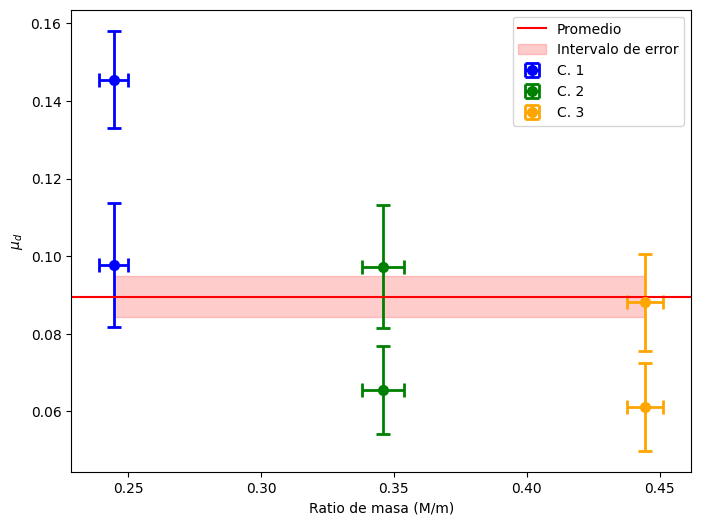

In [35]:
import matplotlib.pyplot as plt


# Sorting data based on M/m ratios
sorted_indices = np.argsort(M_m_ratios)
M_m_ratios_sorted = np.array(M_m_ratios)[sorted_indices]
mu_d_sorted = np.array(mu_d)[sorted_indices]
error_mu_d_sorted = np.array(error_mu_d)[sorted_indices]
M_m_errors_sorted = np.array(M_m_errors)[sorted_indices]

# Plotting the results
plt.figure(figsize=(8, 6))

# Plot each dataset with its own color and legend
for i, dataset in enumerate(datasets):
    plt.errorbar(M_m_ratios_sorted[i*2:(i+1)*2], mu_d_sorted[i*2:(i+1)*2], 
                 xerr=M_m_errors_sorted[i*2:(i+1)*2], yerr=error_mu_d_sorted[i*2:(i+1)*2], 
                 fmt='o', label=dataset["legend"], color=['blue', 'green', 'orange'][i], capsize=5, elinewidth=2, markeredgewidth=2)

# Plot the mean and error band
plt.axhline(mean, color='red', label='Promedio')
plt.fill_between(M_m_ratios_sorted, mean - overall_error, mean + overall_error, color='red', alpha=0.2, label='Intervalo de error')

# Label the axes
plt.xlabel('Ratio de masa (M/m)')
plt.ylabel('$μ_d$')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
C:\Users\xxx\AppData\Local\Temp\ipykernel_18020\2038204963.py:48: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mu_d$', fontsize=14)


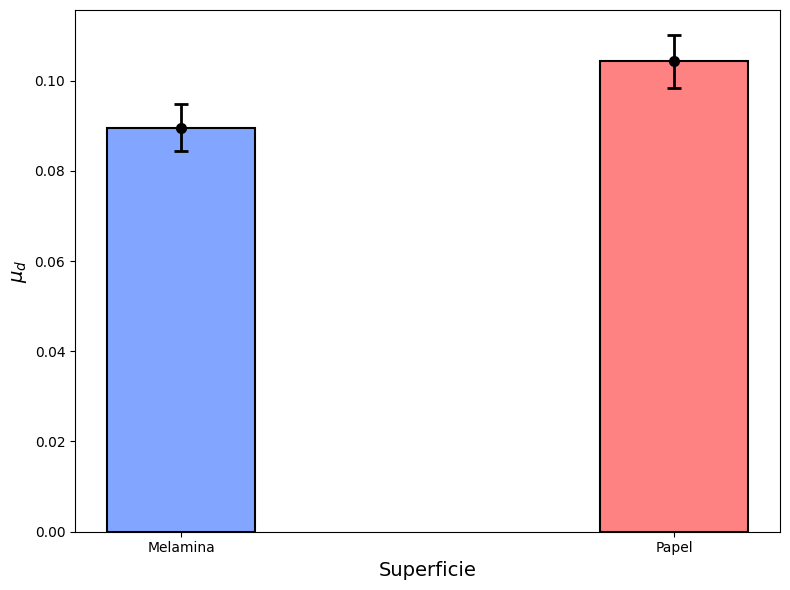

[0.0895661702149082, 0.1042886601649527] [0.005263954214679712, 0.005836374861138634]


In [38]:
# HACER ESTO PARA CADA TIPO DE SUPERFICIE   

datasets = [
    { "file" : 'data_dosplataymadera_oro.csv', "m" : 110 + 2 * 23 + 6, "M" : 72, "dm": 4, "dM": 1 },
    { "file" : 'data_maderayoro_dosplata.csv', "m" : 110 + 6 + 72, "M" : 2 * 23 , "dm": 3, "dM": 2},
    { "file" : 'data_plata_dosplata.csv', "m" : 110 + 23, "M" : 2 * 23, "dm": 2, "dM": 2}
]

datasets_papel = [
    { "file" : 'data_dosplata_oro_PAPEL.csv', "m" : 110 + 2 * 23, "M" : 72, "dm": 3, "dM": 1 },
    { "file" : 'data_tresplata_oro_PAPEL.csv', "m" : 110 + 3 * 23, "M" : 2 * 23, "dm": 4, "dM": 2},
]


import matplotlib.pyplot as plt
import numpy as np

def plot_mus_d_with_error_bar(mus_d, sigmas_mus_d, mean=None, error=None):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the bars for the data
    bar_width = 0.3  # Reduce the width to make the bars less "full"
    x_positions = np.arange(len(mus_d))

    # Create bars: first bar is "Caso mesa" in lighter blue, second bar is "Caso Papel" in lighter red
    colors = [(0.3, 0.5, 1, 0.7), (1, 0.3, 0.3, 0.7)]  # Lighter blue and red with some transparency
    labels = ['Melamina', 'Papel']
    ax.bar(x_positions, mus_d, color=colors, width=bar_width, edgecolor='black', linewidth=1.5)

    # Add error bars on top of bars
    ax.errorbar(x_positions, mus_d, yerr=sigmas_mus_d, fmt='o', color='black', capsize=5, elinewidth=2, markeredgewidth=2)

    if mean is not None:
        # Plot the mean line in red
        ax.axhline(mean, color='red', linewidth=2, label='Promedio')

    # Plot the error bounds using fill_between
    if error is not None:
        ax.fill_between(x_positions, mean - error, mean + error, color='red', alpha=0.2, label='Intervalo de error')

    # Customize the x-axis labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(labels)  # Set labels to "Caso mesa" and "Caso Papel"

    # Customize labels and title
    ax.set_xlabel('Superficie', fontsize=14)
    ax.set_ylabel('$\mu_d$', fontsize=14)

    # Add legend if mean is provided
    if mean is not None:
        ax.legend(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

means = []
errors = []

for datasets_i in [datasets, datasets_papel]:

    mus_d = []
    errors_mu_d = []

    for dataset in datasets_i:
        for i in range(1,3):
            data = pd.read_csv(dataset["file"])
            data = format_pd(data, i)
            M, m = dataset["M"], dataset["m"]
            # se lo sacó copilot del orto
            tiempo = data["t"].values
            posicion = distancia(data["x"].values)
            errores = sigma_d(data["x"].values)

            # Fit the quadratic model to the data
            popt, pcov = curve_fit(modelo_cuadratico, tiempo, posicion, sigma=errores, absolute_sigma=True)

            # Extract the fitted parameters and their uncertainties
            a, _, _ = popt
            error_a = np.sqrt(np.diag(pcov))[0]    
            
            mu = (M * g) + ( m + M ) * a / (m * g)
            dM = dataset["dM"]
            dm = dataset["dm"]
            error_mu = get_error_mu_d(M, m, a, dM, dm, error_a)
            mus_d.append(mu)
            errors_mu_d.append(error_mu)

    mean, overall_error = mean_with_sigma(mus_d, errors_mu_d)

    means.append(mean)
    errors.append(overall_error)

plot_mus_d_with_error_bar(means, errors, None, None)
print(means, errors)

In [37]:
print(propagacion_errores_ratios(35, 182, 3, 2))

0.01661843047450338
